<a href="https://colab.research.google.com/github/Jingut/GoingDeeper/blob/main/GD1_Project_ResNet_Ablation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar() # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHJO7S7/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [4]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [5]:
ds_info.features["label"].num_classes  

2

In [6]:
ds_info.features["label"].names  

['cat', 'dog']

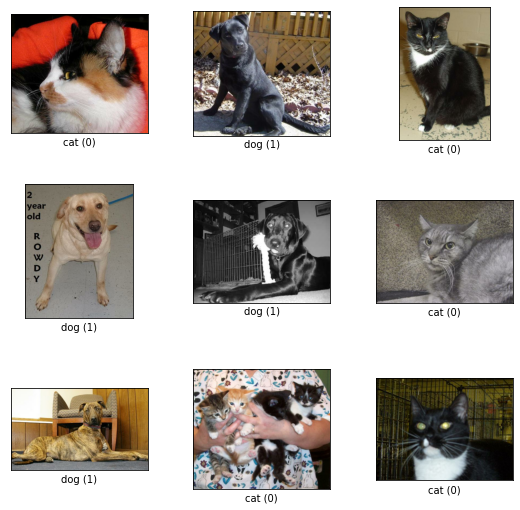

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

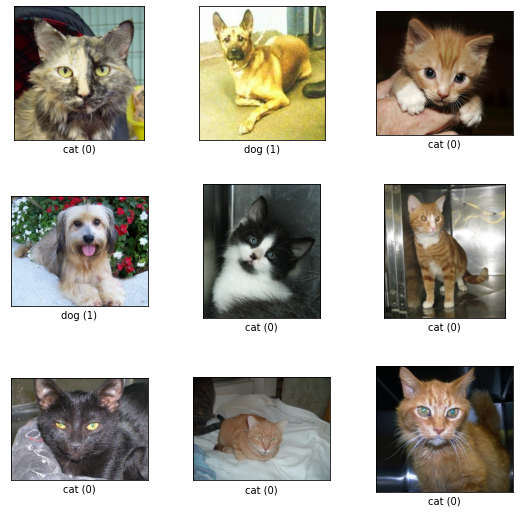

In [8]:
fig = tfds.show_examples(ds_test, ds_info)

In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=32)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=32)

In [12]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


#1) ResNet 기본 블록 구성하기
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

In [13]:
def conv_block(input_layer,
                      channel,
                      kernel_size,
                      strides=1,
                      activation = 'relu',
                      ):
  
    x = input_layer

    x = keras.layers.Conv2D(
    filters = channel,
    kernel_size = kernel_size,
    activation='relu',
    kernel_initializer="he_normal",
    padding='same',
    strides = strides,
    # name=f'conv2D_{block_num}'
    )(x)

    x = keras.layers.BatchNormalization(
    # name=f'batch_normalization_{block_num}'
    )(x)

    x = keras.layers.Activation(
      activation='relu',
      # name=f'activation_{block_num}'
    )(x)

    return x

  # for num_cnn in range(num_cnn):
  #   x = keras.layers.Conv2D(
  #       filters = channel,
  #       kernel_size = (3,3),
  #       activation='relu',
  #       kernel_initializer="he_normal",
  #       padding='same',
  #       strides = (2,2),
  #       name=f'conv2D_{block_num}'
  #   )(x)

  #   x = keras.layers.BatchNormalization(
  #       name=f'batch_normalization_{block_num}'

  #   )(x)

  #   x = keras.layers.Activation(
  #       activation='relu',
  #       name=f'activation_{block_num}'
  #   )(x)

    # x = keras.layers.MaxPooling2D(
    #     pool_size=(2,2),
    #     strides=2,
    #     name=f'stage2_{block_num}_maxpooling'
    # )(x)

  # return x

In [14]:
def res_block (input_layer,
               count_cnn = 3,
               channel = 64,
               block_num = 0,
               is_50 = True,
               is_ResNet = True):
  
  x = input_layer

  if is_50 == True: # ResNet50
    if is_ResNet:
      for i in range(count_cnn):
        if i == 0:
          sc = conv_block(x, channel*4, (1,1), strides=2, activation=None)
          x = conv_block(x, channel, (1,1), strides = 2)
          x = conv_block(x, channel, (3,3))
          x = conv_block(x, channel*4, (1,1), activation = None)
        else:
          sc = x
          x = conv_block(x, channel, (1,1))
          x = conv_block(x, channel, (3,3))
          x = conv_block(x, channel*4, (1,1), activation=None)
                
        x = keras.layers.Add()([x, sc])
        x = keras.layers.Activation('relu')(x)
    else: # Plain ResNet50
      for i in range(count_cnn):
        if block_num > 0 and i == 0:
            x = conv_block(x, channel, (1,1), strides=2)
            x = conv_block(x, channel, (3,3))
            x = conv_block(x, channel*4, (1,1))
        else:
            x = conv_block(x, channel, (1,1))
            x = conv_block(x, channel, (3,3))
            x = conv_block(x, channel*4, (1,1))
  else: # ResNet34
    if is_ResNet:
      for i in range(count_cnn):
        if block_num > 0 and i == 0:
          sc = conv_block(x, channel, (1,1), strides = 2, activation = None)
          x = conv_block(x, channel, (3,3), strides = 2)
          x = conv_block(x, channel, (3,3), strides = 1, activation = 'relu')
        else:
          sc = x
          x = conv_block(x, channel, (3,3), strides = 1)
          x = conv_block(x, channel, (3,3), strides = 1, activation = 'relu')

        x = keras.layers.Add()([x,sc])
        x = keras.layers.Activation('relu')(x)
    else: # Plain ResNet34   
        for i in range(count_cnn):
          if block_num > 0 and i == 0:
            x = conv_block(x, channel, (3,3), strides = 2)
            x = conv_block(x, channel, (3,3))
          else:
            x = conv_block(x, channel, (3,3))
            x = conv_block(x, channel, (3,3))

  return x

In [15]:
def build_resnet(input_shape=(32, 32, 3),
              num_cnn_list=[3,4,6,3],# 블록갯수!
              channel_list=[64,128,256,512],# output출력 설정! 포맷에 맞게 
              num_classes=1,
              is_50 = True,
              is_ResNet=True,
              activation='softmax',
              name = 'ResNet_50'
              ):
  
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    # output = input_layer

    #conv_block 1층!
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for block_num, (count_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
      x = res_block(x, 
                    count_cnn=count_cnn, 
                    channel=channel, 
                    block_num=block_num, 
                    is_50=is_50,
                    is_ResNet=is_ResNet)
        
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, activation=activation, kernel_initializer='he_normal')(x)
    
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=x,
        name=name
    )
    return model



In [16]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False, is_ResNet=True, num_classes=1,activation='sigmoid',name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [17]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_ResNet=True, num_classes=1, activation='sigmoid', name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

일반 모델 생성

In [18]:
plain_34 = build_resnet(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=1,
    activation='sigmoid',
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_121 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        369

In [19]:
plain_50 = build_resnet(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=1,
    activation='sigmoid',
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_154 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        416

#ResNet vs Plain 비교


### 모델 학습 함수


In [20]:
def model_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

In [21]:
learning_rate = 0.001
momentum = 0.9
opt_decay = 0.0001 
batch_size = 128 
epochs = 15

ResNet-34 학습


In [22]:
history_resnet_34 = model_fit(resnet_34, ds_train, ds_test, ds_info, learning_rate, momentum, opt_decay, batch_size, epochs = 15)

Epoch 1/15
145/145 [==============================] - 57s 191ms/step - loss: 0.7039 - accuracy: 0.5416 - val_loss: 0.6933 - val_accuracy: 0.5043
Epoch 2/15
145/145 [==============================] - 25s 170ms/step - loss: 0.6978 - accuracy: 0.5599 - val_loss: 0.6965 - val_accuracy: 0.4913
Epoch 3/15
145/145 [==============================] - 25s 171ms/step - loss: 0.6902 - accuracy: 0.5634 - val_loss: 0.7064 - val_accuracy: 0.4991
Epoch 4/15
145/145 [==============================] - 25s 172ms/step - loss: 0.6835 - accuracy: 0.5761 - val_loss: 0.6997 - val_accuracy: 0.5477
Epoch 5/15
145/145 [==============================] - 24s 169ms/step - loss: 0.6798 - accuracy: 0.5823 - val_loss: 0.6752 - val_accuracy: 0.5668
Epoch 6/15
145/145 [==============================] - 25s 171ms/step - loss: 0.6796 - accuracy: 0.5866 - val_loss: 0.6742 - val_accuracy: 0.5919
Epoch 7/15
145/145 [==============================] - 25s 171ms/step - loss: 0.6730 - accuracy: 0.5966 - val_loss: 0.8012 - val_ac

Plain-34 학습

In [23]:
history_plain_34 = model_fit(plain_34, ds_train, ds_test, ds_info, learning_rate = 0.001, momentum = 0.9, opt_decay = 0.0001, batch_size = 128, epochs = 15)

Epoch 1/15
145/145 [==============================] - 40s 169ms/step - loss: 0.7055 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 2/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6967 - accuracy: 0.5127 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 3/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6940 - accuracy: 0.5353 - val_loss: 0.6943 - val_accuracy: 0.4809
Epoch 4/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6972 - accuracy: 0.5338 - val_loss: 0.6965 - val_accuracy: 0.4800
Epoch 5/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6942 - accuracy: 0.5157 - val_loss: 0.7011 - val_accuracy: 0.4939
Epoch 6/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6974 - accuracy: 0.5284 - val_loss: 0.7184 - val_accuracy: 0.4779
Epoch 7/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6985 - accuracy: 0.5408 - val_loss: 0.8392 - val_ac

ResNet-50 학습

In [24]:
history_resnet_50 = model_fit(resnet_50, ds_train, ds_test, ds_info, learning_rate = 0.001, momentum = 0.9, opt_decay = 0.0001, batch_size = 128, epochs = 15)

Epoch 1/15
145/145 [==============================] - 44s 160ms/step - loss: 0.7616 - accuracy: 0.5319 - val_loss: 0.6936 - val_accuracy: 0.4792
Epoch 2/15
145/145 [==============================] - 22s 153ms/step - loss: 0.7354 - accuracy: 0.5218 - val_loss: 0.6969 - val_accuracy: 0.5009
Epoch 3/15
145/145 [==============================] - 22s 155ms/step - loss: 0.7127 - accuracy: 0.5450 - val_loss: 0.7162 - val_accuracy: 0.5052
Epoch 4/15
145/145 [==============================] - 22s 153ms/step - loss: 0.7168 - accuracy: 0.5373 - val_loss: 0.7038 - val_accuracy: 0.5139
Epoch 5/15
145/145 [==============================] - 22s 153ms/step - loss: 0.7139 - accuracy: 0.5446 - val_loss: 0.7509 - val_accuracy: 0.5642
Epoch 6/15
145/145 [==============================] - 22s 155ms/step - loss: 0.7162 - accuracy: 0.5552 - val_loss: 0.7038 - val_accuracy: 0.5738
Epoch 7/15
145/145 [==============================] - 22s 153ms/step - loss: 0.7138 - accuracy: 0.5455 - val_loss: 0.6903 - val_ac

Plain-50 학습

In [25]:
history_plain_50 = model_fit(plain_50, ds_train, ds_test, ds_info, learning_rate = 0.001, momentum = 0.9, opt_decay = 0.0001, batch_size = 128, epochs = 15)

Epoch 1/15
145/145 [==============================] - 52s 225ms/step - loss: 0.6975 - accuracy: 0.5287 - val_loss: 0.6940 - val_accuracy: 0.4757
Epoch 2/15
145/145 [==============================] - 32s 219ms/step - loss: 0.6980 - accuracy: 0.5261 - val_loss: 0.6946 - val_accuracy: 0.4823
Epoch 3/15
145/145 [==============================] - 32s 219ms/step - loss: 0.7011 - accuracy: 0.5134 - val_loss: 0.6946 - val_accuracy: 0.4931
Epoch 4/15
145/145 [==============================] - 32s 219ms/step - loss: 0.6980 - accuracy: 0.5264 - val_loss: 0.6929 - val_accuracy: 0.5069
Epoch 5/15
145/145 [==============================] - 32s 218ms/step - loss: 0.6960 - accuracy: 0.5194 - val_loss: 0.6967 - val_accuracy: 0.5113
Epoch 6/15
145/145 [==============================] - 32s 218ms/step - loss: 0.7016 - accuracy: 0.5263 - val_loss: 0.7131 - val_accuracy: 0.5097
Epoch 7/15
145/145 [==============================] - 32s 218ms/step - loss: 0.6971 - accuracy: 0.5242 - val_loss: 0.7059 - val_ac

학습 결과 시각화 

- ResNet-34, Plain-34

- Training Loss

- Training Accuracy

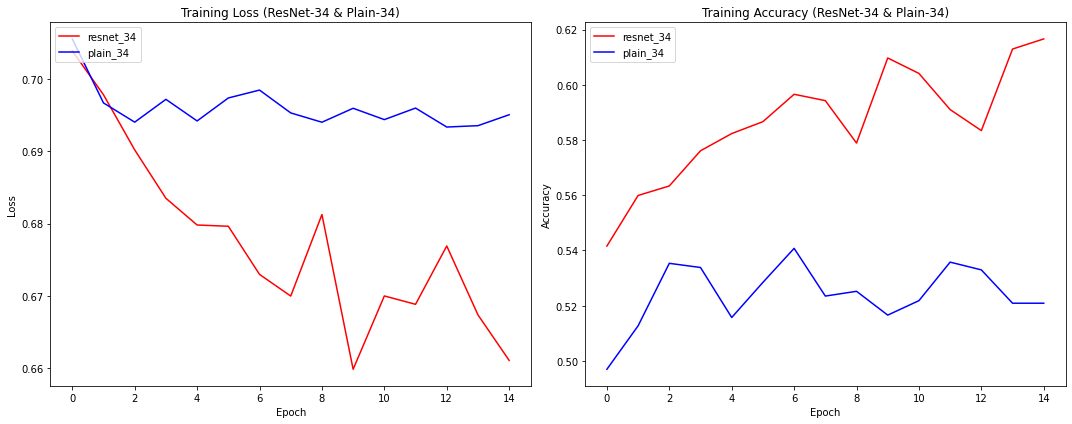

In [26]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_34.png')

plt.show()

- ResNet-50, Plain-50

- Training Loss

- Training Accuracy

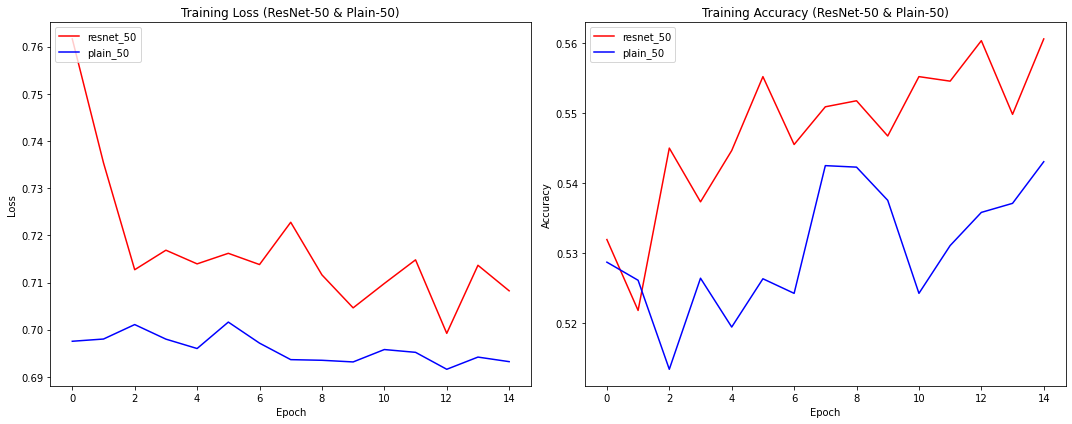

In [27]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_50.png')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50

- Training Loss

- Training Accuracy


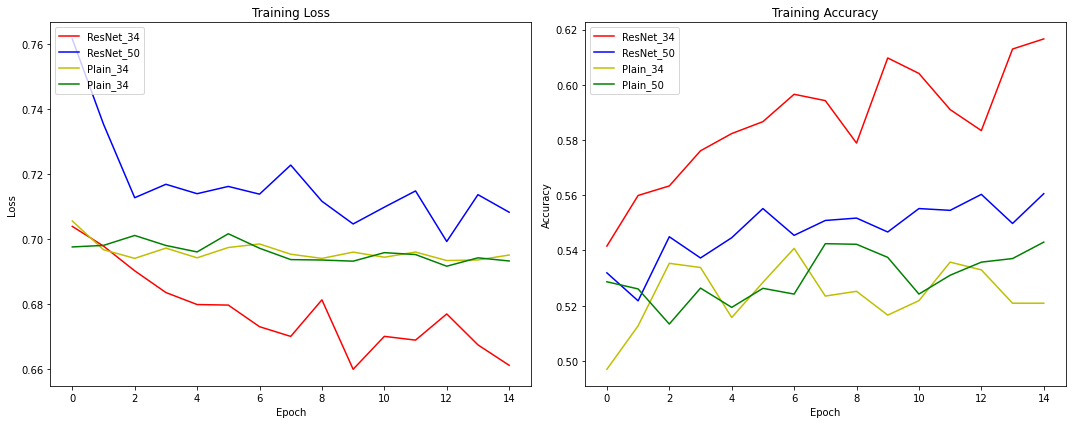

In [28]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Training_Loss_and_Accuracy_of_All.png')

plt.show()

- ResNet-34, Plain-34

- Validation Loss

- Validation Accuracy

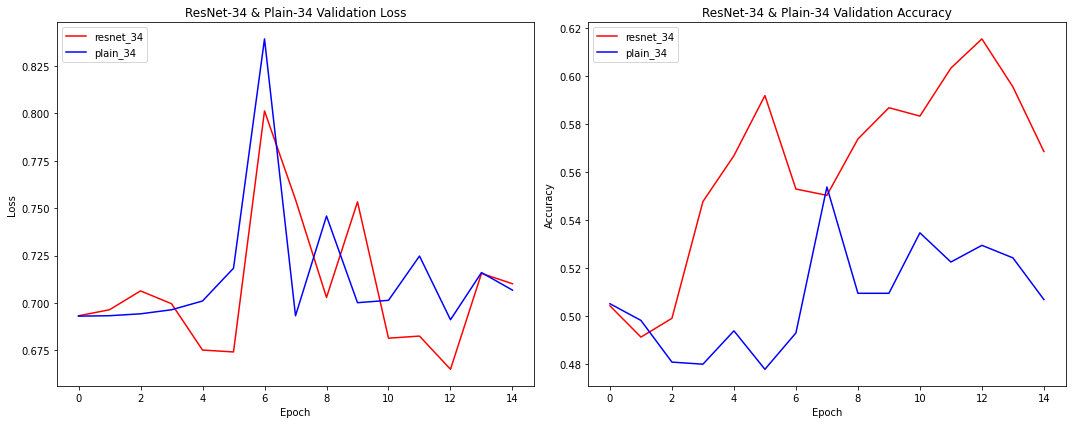

In [29]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_34.png')

plt.show()

-ResNet-50, Plain-50

- Validation Loss

- Validation Accuracy

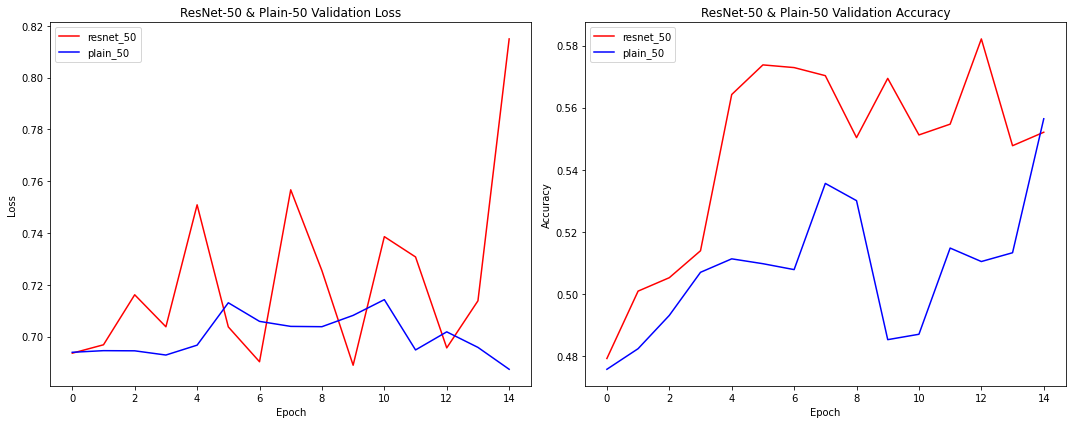

In [30]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_50.png')

plt.show()

-ResNet-34, Plain-34, ResNet-50, Plain-50

- Validation Loss

- Validation Accuracy

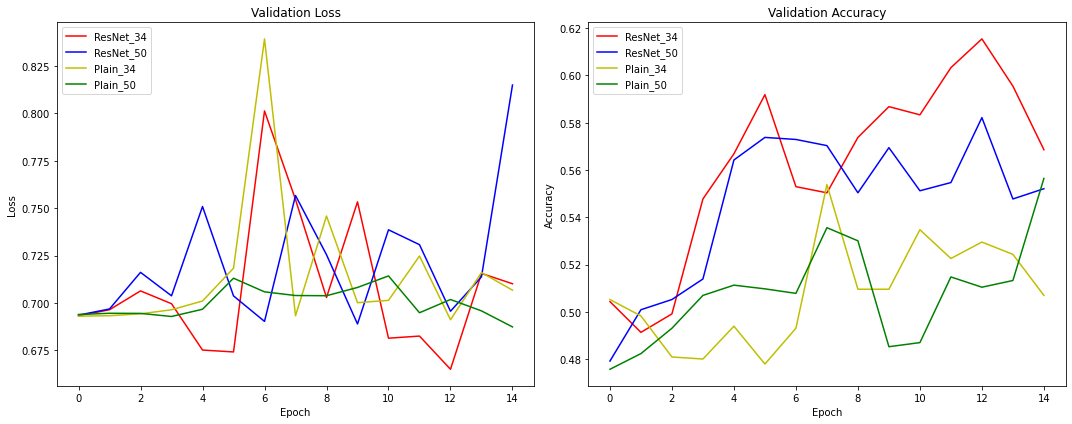

In [31]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('./Validation_Loss_and_Accuracy_of_All.png')

plt.show()

#Ablation

#결론
이번 프로젝트에서는 일반 모델과 shortcut이 적용된 ResNet 모델을 깊이별로 비교해보았습니다.
이미 증명 되어있듯이 그래프를 보면 ResNet모델이 Plain모델보다 성능이 더 좋게 나온 것을 볼 수 있었습니다.

# 회고

---



## - 이번 프로젝트에서 어려웠던 점
출력 레이어를 보고 직접 모델을 구현해보는게 쉽지 않았습니다. 그리고 다음 스테이지의 출력값이 왜 그렇게 바뀌는지 스트라이드 값과 패딩 값을 조절하는 것이 어려웠습니다. 

그리고 아직 함수사용이 익숙치 않았던 것 같습니다. 

그리고 처음에 각각의 블록을 쌓아준다는 개념을 이해하고 모델을 쌓는데 조금 시간이 많이 소요됐던 것 같습니다.


---


## - 프로젝트를 진행하면서 알게된 점
데이터셋 마다 크기도 다르고 클래스의 갯수에 때라 바꿔줘야 할 것 들이 많다고 느꼈습니다.

그리고 어느 정도 레이어를 어떻게 쌓는지 방식은 어떻게 되는지 그리고 레이어 끝에 (출력)을 붙여주어 전레이어의 출력 값을 전달해주는 법도 알게되었습니다.  

---


## - 루브릭 평가지표를 맞추기 위해 시도한 것들
출력 값을 맞추기위해 Pooling이나 레이어에서의 stride, padding값들을 조절하여 출력 숫자를 맞춰주고 그래프를 활용하여 Plain모델과 ResNet모델 끼리의 각각 34, 50레이어를 비교해 주었습니다.





---


## - 자기다짐
레이어를 쌓는 것과 함수사용을 익숙하게 하고, 논문을 틈틈히 봐야 남은 프로젝트를 따라갈 수 있을 듯 싶어 논문을 집중적으로 읽어보는 시간을 가지려고 합니다...


